# Tutorial 2d - *Code Modifications (Visualization)*

This tutorial is an introduction to analyzing results from your code modifications for the NEON Konza Prairie simulation. It uses results from the case you ran in the Day0b and Day2c tutorials, but you don't have to wait for those runs to complete before doing this tutorial. We've pre-staged model results from this simulation in a shared directory so that you can analyze results of your simulations regardless of whether they've completed.

You can also check [NEON visualization](https://ncar.github.io/ncar-neon-books/notebooks/NEON_Visualization_Tutorial.html) tutorial for more advanced visualization features for NEON tower site simulations. 

## In this tutorial

The tutorial has several objectives: 
1. Increase familiarity with `xarray` and `pandas`.
2. Increase knowledge of python packages and their utilities
3. Compare results from original code with the modified code for a NEON tower.


***

<div class="alert alert-block alert-info">
<b>NOTE:</b> In Day 2c, executable code blocks used a Bash shell or had to be executed on the command-line.  In this tutorial, we will be using Python code, and you should directly execute the contents of code blocks by running individual cells in this Jupyter notebook, similar to the Day0b <i>Run NEON</i>, Day1b <i>GlobalVisualization</i>, and Day2b <i>GenericGinglePoint_Visualization</i> tutorials.
</div>

***

There are countless ways of analyzing and processing model data. This tutorial uses Matplotlib, a comprehensive data visualization and plotting library for Python. For more information on Matplotlib, please see the [User's Guide](https://matplotlib.org/stable/users/index.html).

## 1. Load our python packages

Here we are importing python package and libraries we will use to analyze these simulations:

In [1]:
#Import Libraries
%matplotlib inline

import os
import time
import datetime

import numpy as np
import pandas as pd
import xarray as xr

from glob import glob
from os.path import join, expanduser

import matplotlib.pyplot as plt

from scipy import stats

from neon_utils import download_eval_files

Before diving in, we need to specify the NEON site that you simulated in the cell below.   

*The tutorial is currently set to use the KONZ site, which is the site we recommended in the Day0b_NEON_Simulation_Tutorial and Day2c_CodeModification tutorials. If you ran simulations for a different tower site, please change the 4-character site name in quotes below to the same as your simulation.*

For simplicity, we focus on analyzing and evaluating a single year of data. <p>
The code below uses data for **2018**, but data are available through this year. You can select a different year by changing the year in the quotes below.

In [2]:
#Change the 4-character NEON site below to point to your NEON site:
neon_site = "KONZ"

# Select a year for analysis
year = "2018"

## 2. Load and explore CTSM data

When a simulation completes, the data are transferred to an archive directory. In this directory, there are files that include data for every day of the simulation, as well as files that average model variables monthly.

Run the cell below to see a subset of the files listed:


In [3]:
!ls ~/scratch/CLM-NEON-phenologychange/archive/{neon_site}.transient/lnd/hist/*2018*.nc |head -n 10

/home/negins/scratch/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h0.2018-01.nc
/home/negins/scratch/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h0.2018-02.nc
/home/negins/scratch/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h0.2018-03.nc
/home/negins/scratch/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h0.2018-04.nc
/home/negins/scratch/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h0.2018-05.nc
/home/negins/scratch/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h0.2018-06.nc
/home/negins/scratch/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h0.2018-07.nc
/home/negins/scratch/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h0.2018-08.nc
/home/negins/scratch/CLM-NEON-phenologychange/archive/KONZ.transient/lnd/hist/KONZ.transient.clm2.h0.201

**Note:** you won't see these files if your simulation from 2c has not finished.

The NEON tower simulations generate two types of files:
* `*h0*`: Variables that are averaged monthly. One file is available for every month of the simulation.
* `*h1*`: Variables that are recorded every 30 minutes. Values are aggregated into one file for each day of the simulation. Each file includes 48 data points.

**Note:** Only a subset of CLM variables are included on the `*h1*` files, with many more variables included on the monthly-averaged `*h0*` files. A full list of variables that are simulated by CLM is available [on this website](https://escomp.github.io/ctsm-docs/versions/master/html/users_guide/setting-up-and-running-a-case/master_list_nofates.html).

<div class="alert alert-block alert-info">
<b>TIP:</b> For future simulations you can add or remove history file output by modifying the list of variables in <i>hist_fincl2</i> found in your <i>user_nl_clm</i> file (e.g. ~/scratch/CLM-NEON-phenologychange/KONZ.transient/user_nl_clm)
</div>

****

### 2.1 Load data from unmodified CTSM simulations

Here, we want to read and analyze the data from the original (unmodified) CTSM code. 
The below code lists the 30-minute (.h1.) CTSM files for 2018:

In [4]:
# pre-staged simulation:
sim_path = "/scratch/data/day2/KONZ.transient/lnd/hist/"
sim_files = sorted(glob(join(sim_path,neon_site+".transient.clm2.h1."+year+"*.nc")))

print("All simulation files: [", len(sim_files), "files]")
## for brevity we'll just print the first 20 files
print(*sim_files[0:20],sep='\n')

All simulation files: [ 365 files]
/scratch/data/day2/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-01-00000.nc
/scratch/data/day2/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-02-00000.nc
/scratch/data/day2/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-03-00000.nc
/scratch/data/day2/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-04-00000.nc
/scratch/data/day2/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-05-00000.nc
/scratch/data/day2/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-06-00000.nc
/scratch/data/day2/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-07-00000.nc
/scratch/data/day2/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-08-00000.nc
/scratch/data/day2/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-09-00000.nc
/scratch/data/day2/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-10-00000.nc
/scratch/data/day2/KONZ.transient/lnd/hist/KONZ.transient.clm2.h1.2018-01-11-00000.nc
/scratch/data/day2/

Next, let's read and load CTSM history files into memory. 

For this purpose, we will use `open_mfdataset` function, which opens up multiple netcdf files at the same time into one xarray Dataset. You can find more information about this function [here](https://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html). 

**Note:** there are many files, so this will take about a minute.

In [5]:
start = time.time()
ds_ctsm_orig = xr.open_mfdataset(sim_files, decode_times=True, combine='by_coords',parallel=True)
end = time.time()
print("Reading original simulation files took:", end-start, "s.")

Reading original simulation files took: 55.31088423728943 s.


The next step, exploring the data, is not required, but will allow you to explore the python dataset we just created and become familiar with the data structure.

Run the below cell to find more information about the data:

In [6]:
ds_ctsm_orig

<xarray.Dataset>
Dimensions:       (time: 17520, levgrnd: 25, levsoi: 20, levlak: 10,
                   levdcmp: 25, hist_interval: 2, lndgrid: 1)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:29:59.12...
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levsoi        (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
Dimensions without coordinates: hist_interval, lndgrid
Data variables: (12/42)
    mcdate        (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mcsec         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mdcur         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mscur         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    nstep         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    time_bounds   (time, hist_interval) datetime64[ns] dask.array<chunksize=(96, 2), meta=np.ndarray>
    ...            ...
    HR            (time, lndgrid) float32 dask.array<chunksize=(96, 1), meta=np.ndarray>
    NET_NMIN_vr   (time, levdcmp, lndgrid) float32 dask.array<chunksize=(96, 25, 1), meta=np.ndarray>
    SNOW_DEPTH    (time, lndgrid) float32 dask.array<chunksize=(96, 1), meta=np.ndarray>
    SOILC_vr      (time, levsoi, lndgrid) float32 dask.array<chunksize=(96, 20, 1), meta=np.ndarray>
    TBOT          (time, lndgrid) float32 dask.array<chunksize=(96, 1), meta=np.ndarray>
    TSOI          (time, levgrnd, lndgrid) float32 dask.array<chunksize=(96, 25, 1), meta=np.ndarray>
Attributes: (12/99)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 05/18/22 20:38:53
    source:                               Community Terrestrial Systems Model
    hostname:                             aws-hpc6a
    ...                                   ...
    cft_irrigated_switchgrass:            60
    cft_tropical_corn:                    61
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     minute_30

In the output, you can click on Dimensions, Coordinates, Data Variables, and Attributes to expand and see the details and metadata associated with this dataset.

If you click on Data Variables, you will see a list of all the available variables. You can click on the ‘note’ icon at the right end of the line for each variable to see a description of the variable (the long_name) and its units, as well as other information. Here are a few questions to consider:

Questions to consider

1. What variables are available in the dataset?

2. What is the long_name and unit of the variable FSH?

3. Can you find the dimensions of this variable?


<div class="alert alert-block alert-info">

<b>💡 Tip: </b>  Xarray has built-in plotting functions. For quick inspection of a variable, we can use .plot() to see it. Xarray plotting functionality is a thin wrapper around the popular `matplotlib` library.

</div>

Let's quickly inspect GPP from original simulation.

<div class="alert alert-block alert-info">

<b>Defined:</b>  Gross Primary Production (GPP) is the total amount of CO<sub>2</sub> that is fixed by plants through photosynthesis.

</div>

The code below will make a basic plot of the Gross Primary Production (GPP) variable:

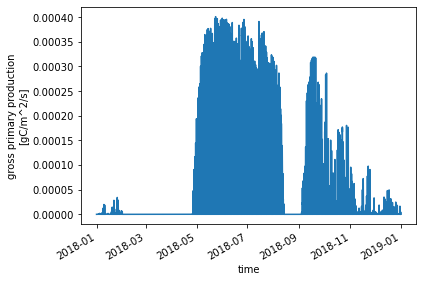

In [7]:
ds_ctsm_orig.GPP.plot() ;

One thing that jumps out from this plot is a dip in GPP in August-September.

This points to some of the challenges in representing stress deciduous phenology used for some plant functional types (PFTs).  The [CLM5 technote has more information about phenology](https://escomp.github.io/ctsm-docs/versions/master/html/tech_note/Vegetation_Phenology_Turnover/CLM50_Tech_Note_Vegetation_Phenology_Turnover.html). Thisis an area that additional research and development can help!

In this specific case, the dip in GPP is related to biases in the input data from NEON, specifically, the zero precipitation that's reported for much of the summer.  Other nearby precipitation sensors suggest that this is not realistic and is potentially a problem with the NEON precipitation sensor. We're working with NEON scientists to address this issue.

Caveats aside, let's go back to the results we have.

---

You can select to plot only specific time period using `.sel` option. 

For example,let's check GPP for June of 2018:

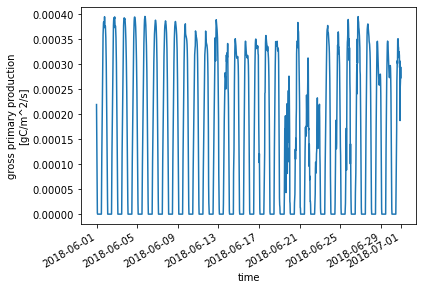

In [8]:
ds_ctsm_orig.GPP.sel(time=slice('2018-06-01', '2018-06-30')).plot() ;

By now you might have noticed the units of GPP in the CTSM history output files. If not, you can check:  


In [9]:
ds_ctsm_orig.GPP.units

'gC/m^2/s'

Let's change the unit from g C m<sup>-2</sup> s<sup>-1</sup> to g C m<sup>-2</sup> day<sup>-1</sup>:

**NOTE:** We're still looking at half hourly data so converting to a daily flux is somewhat misleading, but let's go with this (for now). 

In [10]:
## Don't accidentally run this cell more than once!
ds_ctsm_orig['GPP'] = ds_ctsm_orig['GPP']*60*60*24
ds_ctsm_orig['GPP'].attrs['units'] = 'gC/m^2/day'

Let's remake the plot from above, using the new unit:

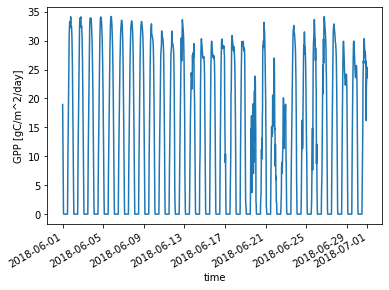

In [11]:
ds_ctsm_orig.GPP.sel(time=slice('2018-06-01', '2018-06-30')).plot() ;

### 2.2 Load data from modified CTSM simulations

We'll follow a similar procedure as above to load data from the modified CTSM simulations

In [12]:
# pre-staged simulation results (with rain_threshold = 1):
sim_path = "/scratch/data/day2/KONZ.transient_phenologychange/lnd/hist/"

sim_files_mod = sorted(glob(join(sim_path,neon_site+".transient.clm2.h1."+year+"*.nc")))

print("All simulation files from modified simulation: [", len(sim_files_mod), "files]")
# Here, just printing the last 20 files
print(*sim_files_mod[-20:None],sep='\n')

All simulation files from modified simulation: [ 365 files]
/scratch/data/day2/KONZ.transient_phenologychange/lnd/hist/KONZ.transient.clm2.h1.2018-12-12-00000.nc
/scratch/data/day2/KONZ.transient_phenologychange/lnd/hist/KONZ.transient.clm2.h1.2018-12-13-00000.nc
/scratch/data/day2/KONZ.transient_phenologychange/lnd/hist/KONZ.transient.clm2.h1.2018-12-14-00000.nc
/scratch/data/day2/KONZ.transient_phenologychange/lnd/hist/KONZ.transient.clm2.h1.2018-12-15-00000.nc
/scratch/data/day2/KONZ.transient_phenologychange/lnd/hist/KONZ.transient.clm2.h1.2018-12-16-00000.nc
/scratch/data/day2/KONZ.transient_phenologychange/lnd/hist/KONZ.transient.clm2.h1.2018-12-17-00000.nc
/scratch/data/day2/KONZ.transient_phenologychange/lnd/hist/KONZ.transient.clm2.h1.2018-12-18-00000.nc
/scratch/data/day2/KONZ.transient_phenologychange/lnd/hist/KONZ.transient.clm2.h1.2018-12-19-00000.nc
/scratch/data/day2/KONZ.transient_phenologychange/lnd/hist/KONZ.transient.clm2.h1.2018-12-20-00000.nc
/scratch/data/day2/KON

In [13]:
start = time.time()
ds_ctsm_mod = xr.open_mfdataset(sim_files_mod, decode_times=True, combine='by_coords',parallel=True)
end = time.time()
print("Reading modified simulation files took:", end-start, "s.")

Reading modified simulation files took: 50.38145565986633 s.


Similar to above, we can get a quick preliminary look at GPP from the modified simulation:

In [14]:
ds_ctsm_mod

<xarray.Dataset>
Dimensions:       (time: 17520, levgrnd: 25, levsoi: 20, levlak: 10,
                   levdcmp: 25, hist_interval: 2, lndgrid: 1)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:29:59.12...
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levsoi        (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
Dimensions without coordinates: hist_interval, lndgrid
Data variables: (12/42)
    mcdate        (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mcsec         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mdcur         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    mscur         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    nstep         (time) float64 dask.array<chunksize=(96,), meta=np.ndarray>
    time_bounds   (time, hist_interval) datetime64[ns] dask.array<chunksize=(96, 2), meta=np.ndarray>
    ...            ...
    HR            (time, lndgrid) float32 dask.array<chunksize=(96, 1), meta=np.ndarray>
    NET_NMIN_vr   (time, levdcmp, lndgrid) float32 dask.array<chunksize=(96, 25, 1), meta=np.ndarray>
    SNOW_DEPTH    (time, lndgrid) float32 dask.array<chunksize=(96, 1), meta=np.ndarray>
    SOILC_vr      (time, levsoi, lndgrid) float32 dask.array<chunksize=(96, 20, 1), meta=np.ndarray>
    TBOT          (time, lndgrid) float32 dask.array<chunksize=(96, 1), meta=np.ndarray>
    TSOI          (time, levgrnd, lndgrid) float32 dask.array<chunksize=(96, 25, 1), meta=np.ndarray>
Attributes: (12/99)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 05/24/22 03:01:22
    source:                               Community Terrestrial Systems Model
    hostname:                             aws-hpc6a
    ...                                   ...
    cft_irrigated_switchgrass:            60
    cft_tropical_corn:                    61
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     minute_30

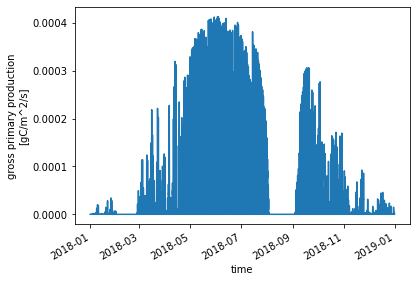

In [15]:
ds_ctsm_mod.GPP.plot() ;

We should change the GPP units to match the change we made in the unmodified simulations

In [16]:
## Don't accidentally run this cell more than once!
ds_ctsm_mod['GPP'] = ds_ctsm_mod['GPP']*60*60*24
ds_ctsm_mod['GPP'].attrs['units'] = 'gC/m^2/day'

### 2.3 Compare modified and unmodified simulations

Since our code modifications change phenology, let's start by looking at leaf area index. 

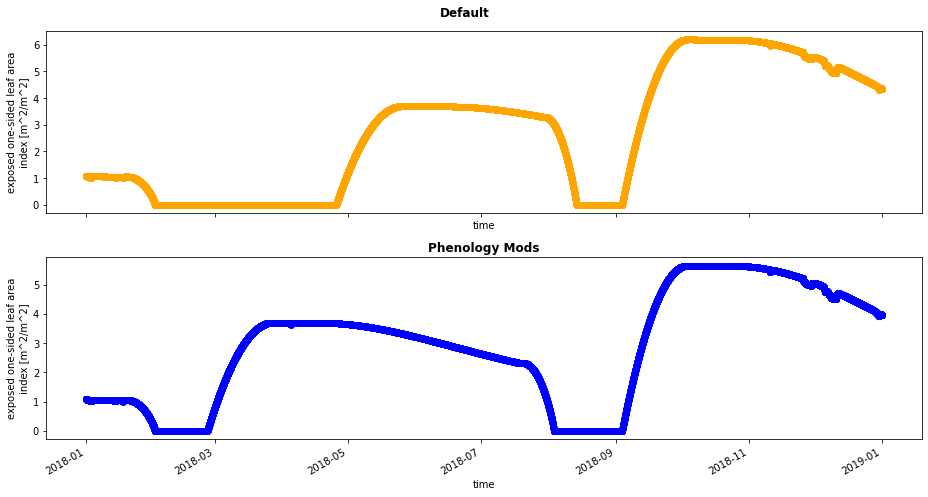

In [17]:
fig, axes = plt.subplots(nrows=2, figsize=(13,7),sharex=True)
ds_ctsm_orig.ELAI.plot(ax=axes[0], color='orange',marker="o")
plt.suptitle('Default',weight='bold')
ds_ctsm_mod.ELAI.plot(ax=axes[1], color='blue',marker="o")
plt.title('Phenology Mods',weight='bold')

plt.tight_layout(); 

**Question**: Can you see any diffences between the two simulations? How does changing the rain threshold change patterns (onset, peak, etc.) of LAI?

Next let's inspect GPP from both simulations for April 2018. Note that we can overlay the two simulations onto a single plot. 

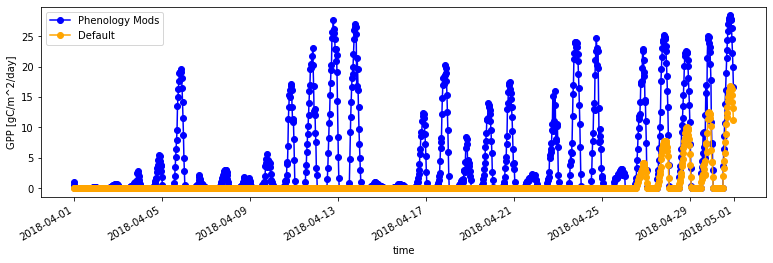

In [18]:
# You can plot the two simulations together
fig = plt.subplots(nrows=1, figsize=(13,3.5))
ds_ctsm_mod.GPP.sel(time='2018-04').plot(color='blue',marker="o", label='Phenology Mods')
ds_ctsm_orig.GPP.sel(time='2018-04').plot(color='orange',marker="o", label='Default') 
# and add a legend (this is facilitated with the 'label' information) 
plt.legend() ;

**Questions**: 
1. How did our code modificatons change LAI and GPP relative to the default parameterizaiton for `rain_threshold`?
2. Can you explain why this occured in 2018?
3. Is this modification justified, based on observations from the site? Let's find out in the next section!

______________________________________________________________

## 3. Explore NEON Tower Observation Data

### 3.1 Download NEON data

<div class="alert alert-block alert-info">

<b>💡 NOTE: </b>  NEON provides observational flux data at 30 minute time intervals that we can use for model evaluation. Here, NEON data with the least restrictive quality control flag are pulled from the API for model evaluation. The data have been preprocessed by NEON, including unit conversions and gap-filling using a redundant data stream regression and/or filled using a Marginal Distribution Sampling (MDS) gap-filling technique when redundant data streams are unavailable. The data are formatted and supplied as monthly netCDF files.

</div>

The next step uses a pre-established function (`download_eval_files`) to download the NEON observational data files for the site and year specified above. The preprocessed NEON data are available for download from NEON’s GCS (Google Cloud Storage) bucket, with the full listing of available data [here](https://storage.googleapis.com/neon-ncar/listing.csv).

If you would like to download all available NEON evaluation data from this site, change the word year to "all" (quotes included) below: `download_eval_files(neon_site, eval_dir, "all")`

Run the cells below to download available NEON data from the site and year we selected above:

In [20]:
# First we need to create a directory to store the data 
# This cell uses bash magic, sounds exciting doesn't it?  (Nothing to worry about, just run the cell!) 
!mkdir ~/scratch/evaluation_files

In [21]:
# Then we'll dowload the data from NEON (this is in python)
eval_dir = "/scratch/"+os.environ['USER']+"evaluation_files/"
download_eval_files(neon_site, eval_dir, year)

Download finished successfully for listing.csv .
Download finished successfully for /scratch/neginsevaluation_files/KONZ/KONZ_eval_2018-01.nc .
Download finished successfully for /scratch/neginsevaluation_files/KONZ/KONZ_eval_2018-02.nc .
Download finished successfully for /scratch/neginsevaluation_files/KONZ/KONZ_eval_2018-03.nc .
Download finished successfully for /scratch/neginsevaluation_files/KONZ/KONZ_eval_2018-04.nc .
Download finished successfully for /scratch/neginsevaluation_files/KONZ/KONZ_eval_2018-05.nc .
Download finished successfully for /scratch/neginsevaluation_files/KONZ/KONZ_eval_2018-06.nc .
Download finished successfully for /scratch/neginsevaluation_files/KONZ/KONZ_eval_2018-07.nc .
Download finished successfully for /scratch/neginsevaluation_files/KONZ/KONZ_eval_2018-08.nc .
Download finished successfully for /scratch/neginsevaluation_files/KONZ/KONZ_eval_2018-09.nc .
Download finished successfully for /scratch/neginsevaluation_files/KONZ/KONZ_eval_2018-10.nc .
D

### 3.2 Load NEON data

Now, let's read these downloaded evaluation files from NEON:

In [22]:
eval_path = os.path.join(eval_dir,neon_site)
eval_files = sorted(glob(join(eval_path,neon_site+"_eval_"+year+"*.nc")))

start = time.time()
ds_eval = xr.open_mfdataset(eval_files, decode_times=True, combine='by_coords')
end = time.time()
print("Reading all observation files took:", end-start, "s.")

Reading all observation files took: 0.18925261497497559 s.


### 3.3 Inspect NEON data

Let's inspect the evaluation files from NEON quickly: 

In [23]:
ds_eval

<xarray.Dataset>
Dimensions:          (lat: 1, time: 17520, lon: 1)
Coordinates:
  * lat              (lat) float64 39.1
  * lon              (lon) float64 263.4
  * time             (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:30:00
Data variables: (12/15)
    LATIXY           (time, lat) float64 dask.array<chunksize=(1488, 1), meta=np.ndarray>
    LONGXY           (time, lon) float64 dask.array<chunksize=(1488, 1), meta=np.ndarray>
    NEE              (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    FSH              (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    EFLX_LH_TOT      (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    GPP              (time, lat, lon) float64 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    ...               ...
    NEE_fqc          (time, lat, lon) int32 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    FSH_fqc          (time, lat, lon) int32 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    EFLX_LH_TOT_fqc  (time, lat, lon) int32 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    GPP_fqc          (time, lat, lon) int32 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    Ustar_fqc        (time, lat, lon) int32 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
    Rnet_fqc         (time, lat, lon) int32 dask.array<chunksize=(1488, 1, 1), meta=np.ndarray>
Attributes:
    created_on:     Mon Nov  1 23:06:47 2021
    created_by:     David Durden
    created_from:   /home/ddurden/eddy/tmp/CLM/KONZ/KONZ_2018-01-01_2021-10-0...
    NEON site:      KONZ
    TimeDiffUtcLt:  -6
    created_with:   flow.api.clm.R
    supported_by:   This data development was funded by the National Science ...

Let's check GPP from NEON files. What are the units of GPP from NEON files?

In [24]:
ds_eval.GPP

<xarray.DataArray 'GPP' (time: 17520, lat: 1, lon: 1)>
dask.array<concatenate, shape=(17520, 1, 1), dtype=float64, chunksize=(1488, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 39.1
  * lon      (lon) float64 263.4
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:30:00
Attributes:
    units:      umolm-2s-1
    long_name:  gross primary productivity
    mode:       time-dependent

**Question:** Do you remember the units of GPP from CTSM simulations?

We should convert the units from NEON data to match the CTSM units (keep in mind that we also converted the units). 

We can convert umol m<sup>-2</sup> s<sup>-1</sup> to g C m<sup>-2</sup> s<sup>-1</sup> by using molecular weight of carbon. We also want to convert time units from seconds to days. 

In [25]:
#-- convert GPP units from  umolm-2s-1 to gc/m2/s
ds_eval['GPP'] = ds_eval['GPP']*(12.01/1000000)

#-- convert from gc/m2/s to gc/m2/day
ds_eval['GPP'] = ds_eval['GPP']*60*60*24
ds_eval['GPP'].attrs['units'] = 'gC/m^2/day'

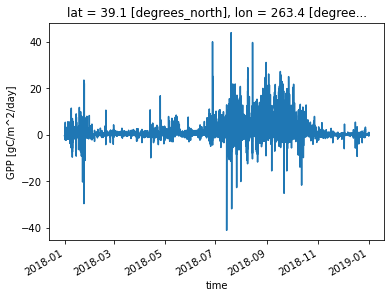

In [26]:
ds_eval.GPP.plot() ;


Flux towers actually measure net ecosystem exchange, or NEE, and a statistical model is then used to estimate GPP. In evaluating CLM simulations of GPP against NEON observations, we are actually comparing a process model (CLM) against an observationally-constrained statistical model (NEON).

___________________________

## 4. Compare CLM and NEON data¶
### 4.1 Format all data
So far, we have loaded observational data from NEON and model data from CLM for two simulations (original and modified). In this section we will compare observed and simulated GPP fluxes. You can also explore other available variables using the below code.

<div class="alert alert-danger">
  <strong>A note about model timestamps:</strong> 
    
The CTSM history includes an initial 0th timestep for each model simulation. This offset in the time dimension can cause challenges when analyzing and evaluating model data if not treated properly. You may notice in the last line of the below cell, we shift the value by -1 to address this issue. In tutorials from Day1b and Day2b, we also handled it using the fix_time function when loading the netCDF files. 
</div>

Run the following cells of code to extract the variables needed for this notebook and create a single dataframe that includes all the extracted variables:

In [27]:
#Convert NEON data to a Pandas Dataframe for easier handling:
#-- fields to extract
eval_vars = ['GPP','NEE','EFLX_LH_TOT']

df_all = pd.DataFrame({'time':ds_eval.time})

for var in eval_vars:
    field = np.ravel ( ds_eval[var])     
    df_all[var]=field

We can inspect the dataframe created:

In [28]:
df_all.head()

,time,GPP,NEE,EFLX_LH_TOT
0,2018-01-01 00:00:00,-0.293934,0.532182,-1.200724
1,2018-01-01 00:30:00,-0.229756,0.459569,-4.083161
2,2018-01-01 01:00:00,-0.367755,0.583214,-3.010144
3,2018-01-01 01:30:00,-0.340121,0.548177,-2.603810
4,2018-01-01 02:00:00,-0.394974,0.593901,-2.281186


In [29]:
#Convert CTSM data to a Pandas Dataframe for easier handling:
ctsm_vars = ['GPP','AR','HR','ELAI','FCEV','FCTR','FGEV']
df_ctsm = pd.DataFrame({'time':ds_ctsm_orig.time})

for var in ctsm_vars:
    sim_var_name = "sim_"+var+"_orig"
    df_all[sim_var_name]=np.ravel(ds_ctsm_orig[var]) 
    df_all[sim_var_name]=df_all[sim_var_name].shift(-1).values

    sim_var_name = "sim_"+var+"_mod"
    df_all[sim_var_name] = np.ravel(ds_ctsm_mod[var])
    df_all[sim_var_name]=df_all[sim_var_name].shift(-1).values

### 4.2 Plotting GPP Time Series (Daily Average)

This creates a time series plot comparing daily average latent heat flux from observations (NEON) and simulations (CLM). To start, we need to calculate the daily averages. Run the below cells of code to create the averages and plot. *Now our conversion of GPP to g C m<sup>-2</sup> day<sup>-1</sup> makes sense!*

First, we need to extract year, month, day and hour from time column

In [30]:
#-- extract year, month, day, hour information from time
df_all['year'] = df_all['time'].dt.year
df_all['month'] = df_all['time'].dt.month
df_all['day'] = df_all['time'].dt.day
df_all['hour'] = df_all['time'].dt.hour

Next, calculate daily average:

In [31]:
df_daily = df_all.groupby(['year','month','day']).mean().reset_index()
df_daily['time']=pd.to_datetime(df_daily[["year", "month", "day"]])


Using the daily averages, we will create a plot using Python’s [matplotlib package](https://matplotlib.org/).

Run the below cell to create the plot:

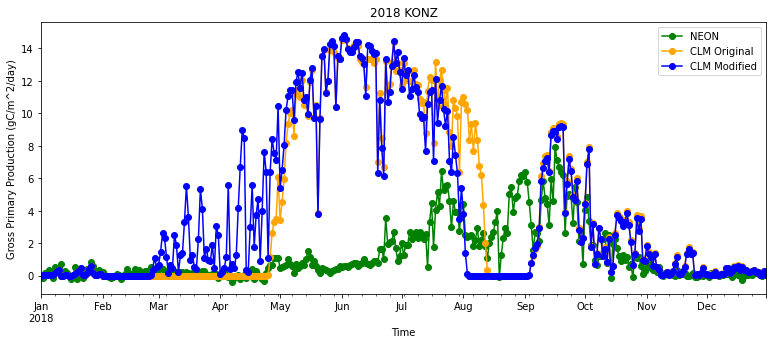

In [32]:
plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')
        
ax = plt.gca()
df_daily.plot ( x= 'time', y = 'GPP' , marker = 'o' ,ax =ax , color = 'g',label="NEON")
df_daily.plot ( x= 'time', y = "sim_GPP_orig" , marker = 'o' ,ax =ax , color = 'orange',label="CLM Original")
df_daily.plot ( x= 'time', y = "sim_GPP_mod" , marker = 'o' ,ax =ax , color = 'b',label="CLM Modified")

plt.xlabel('Time')
# here keeping track of units is helpful agian!
plt.ylabel("Gross Primary Production ("+ds_eval.GPP.attrs['units']+')')
plt.title(year+" "+neon_site)
plt.show()

**Are the simulations and observations in the plot similar?**

Remember that there are some problems with the precipitation data available for the model simulations that affect phenology during the summer and fall.
Also keep in mind that NEON GPP is calculated from observed NEE using a statistical model.

**Questions:**
1. When is NEON GPP highest at this site? When is it lowest? <br>
1. Do patterns of CLM GPP match NEON data? Why or why not? 
1. How do the CLM simulations compare to NEON data **in the spring** for the default and modified cases?
1. As we saw above, the modified code changed phenology so that LAI and GPP were higher earlier in the simulation. Does this change improve simulated GPP?

---

In addition to looking at means, it is important to also look at variability, as this gives us an indication of when and where simulations are outside the range of observed values.

Let’s explore variability by adding the daily standard deviation as a shaded area to the plot:


In [33]:
df_daily_std = df_all.groupby(['year','month','day']).std().reset_index()
df_daily_std['time'] = pd.to_datetime(df_daily_std[["year", "month", "day"]])

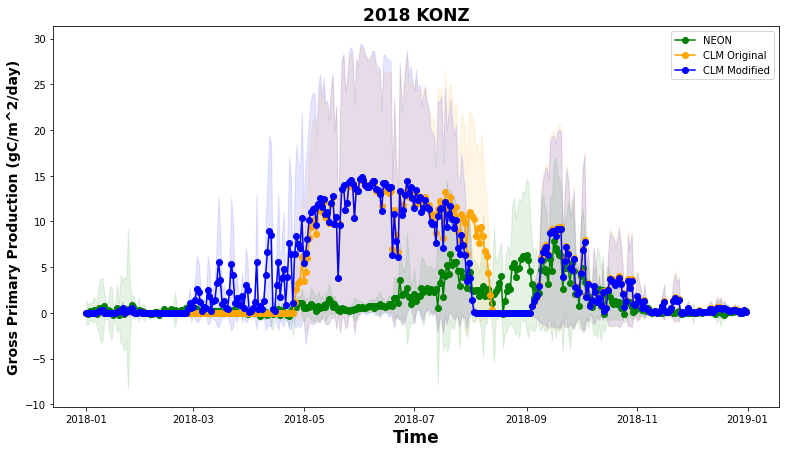

In [34]:
plt.figure(num=None, figsize=(13, 7),  facecolor='w', edgecolor='k')

plt.plot ( df_daily.time, df_daily['GPP'], marker = 'o' , color = 'g',label="NEON")
plt.plot ( df_daily.time, df_daily['sim_GPP_orig'], marker = 'o' , color = 'orange',label="CLM Original")
plt.plot ( df_daily.time, df_daily['sim_GPP_mod'], marker = 'o' , color = 'b',label="CLM Modified")

plt.fill_between(df_daily.time, df_daily['GPP']-df_daily_std['GPP'], df_daily['GPP']+df_daily_std['GPP'] ,alpha=0.1, color = 'g')
plt.fill_between(df_daily.time, df_daily['sim_GPP_orig']-df_daily_std['sim_GPP_orig'], df_daily['sim_GPP_orig']+df_daily_std['sim_GPP_orig'] ,alpha=0.1, color = 'orange')
plt.fill_between(df_daily.time, df_daily['sim_GPP_mod']-df_daily_std['sim_GPP_mod'], df_daily['sim_GPP_mod']+df_daily_std['sim_GPP_mod'] ,alpha=0.1, color = 'b')

plt.legend()
plt.xlabel('Time', fontweight='bold',fontsize=17)
plt.ylabel("Gross Primary Production ("+ds_eval.GPP.attrs['units']+')',fontweight='bold',fontsize=14)
plt.title(year+" "+neon_site, fontweight='bold',fontsize=17)
plt.show()

The standard deviation allows us to see when CLM underpredicts or overpredicts the NEON tower observations.

#### **Questions to consider:**

1. Do fluxes simulated by CLM with different `rain_threshold` fall within the range of NEON tower observation variability? <br>
1. What times of year does CLM shows the best and worst performance in predicting GPP? <br>

### 4.3 [Optional] Extract and save your data in `.csv` format:
If you are unfamiliar with reading and using the netcdf file format that model and evaluation data are provided, you can save data different formats. The next cell of code will save the data we processed (e.g., loaded, averaged) in .csv, or comma-seperated file format.


In [35]:
# create a directory to write out data
!mkdir ~/preprocessed_data/

mkdir: cannot create directory ‘/home/negins/preprocessed_data/’: File exists


In [36]:
csv_dir = "~/preprocessed_data/"

#create the directory if it does not exist:
if not os.path.isdir(csv_dir):
    os.makedirs(csv_dir)
    
csv_out = os.path.join(csv_dir, "preprocessed_"+neon_site+"_"+year+".csv")
df_all.to_csv(csv_out,index=False)

In [37]:
# Check the .csv file was written out
!ls ~/preprocessed_data/

preprocessed_KONZ_2018.csv


## 5. Compare CLM and NEON latent heat flux
In this section we will compare observed and simulated **latent heat fluxes**. You can also explore other available variables with this code

### 5.1 What is latent heat flux?

Below we explore how well CLM simulates latent heat flux, which is directly observed at NEON towers. Latent heat flux is the energy for water evaporation from the ecosystem. Latent heat flux is a combination of plant transpiration, evaporation from leaf surfaces (e.g., from dew, after precipitation events, etc.), and evaporation from the soil:

$$ Latent Heat Flux = Transpiration + Canopy Evaporation + Ground Evaporation $$

Although NEON towers cannot distinguish how much each of these processes contributes to latent heat flux, CLM simulations can help us to disentangle the role of each. 

First we will calculate latent heat flux simulated by CLM by summing the component fluxes in the above equation. The CLM variables are:

>$FCEV$: Canopy evaporation (W m<sup>-2</sup>) <br>
>$FCTR$: Canopy transpiration (W m<sup>-2</sup>) <br>
>$FGEV$: Ground evaporation (W m<sup>-2</sup>) <br>

*Run the below cell to calculate simulated latent heat flux*

In [38]:
sims = ['orig','mod']

for sim in sims:
    clm_var = 'sim_EFLX_LH_TOT_'+sim

    #EFLX_LH_TOT = FCEV + FCTR +FGEV
    df_all [clm_var] = df_all['sim_FCEV_'+sim] \
                     + df_all['sim_FCTR_'+sim]\
                     + df_all['sim_FGEV_'+sim]


Let's calculate daily averages:

In [39]:
df_daily = df_all.groupby(['year','month','day']).mean().reset_index()
df_daily['time']=pd.to_datetime(df_daily[["year", "month", "day"]])

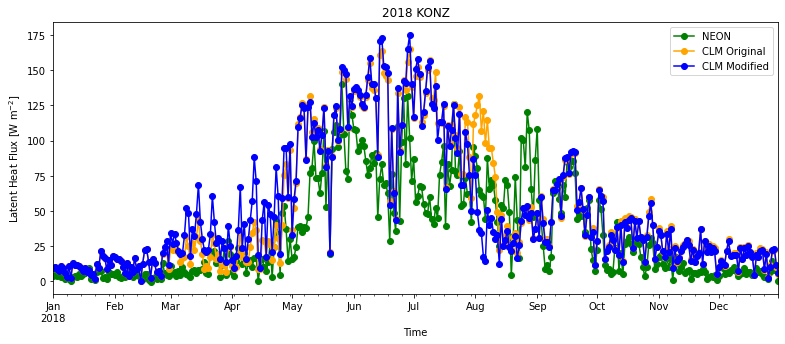

In [40]:
plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')
        
ax = plt.gca()
df_daily.plot ( x= 'time', y = 'EFLX_LH_TOT' , marker = 'o' ,ax =ax , color = 'g',label="NEON")
df_daily.plot ( x= 'time', y = "sim_EFLX_LH_TOT_orig" , marker = 'o' ,ax =ax , color = 'orange',label="CLM Original")
df_daily.plot ( x= 'time', y = "sim_EFLX_LH_TOT_mod" , marker = 'o' ,ax =ax , color = 'b',label="CLM Modified")

plt.xlabel('Time')
plt.ylabel("Latent Heat Flux [W m$^{-2}$]")
plt.title(year+" "+neon_site)
plt.show()

#### **Questions to consider:**
1. How well does CLM simulate observed latent heat flux? What times of year does CLM overestimate or underestimate observed latent heat flux? 
1. How different are the original and modified simulations? Is one noticably more accurate than the other? 
1. Which component flux (transpiration, canopy evaporation, ground evaporation) seems most likely to contribute to the mismatch between simulations and observations? 

### 5.2: Monthly Averages & Component Fluxes of Latent Heat Flux

Next we will disentangle whether transpiration, canopy evaporation, or ground evaporation is the dominant contribution to latent heat flux during each month using CLM data. As mentioned in section 5.1, NEON observations cannot distinguish how much each of these processes contributes to latent heat fluxes. 

*Run the cell below to calculate monthly averages:*

In [41]:
df_monthly = df_all.groupby(['year','month']).mean().reset_index()
df_monthly["day"]=15
df_monthly['time']=pd.to_datetime(df_monthly[["year", "month","day"]])

**Next, create a stacked bar chart showing components of simulated latent heat flux over different months.**

*Run the cell below to create the plot*

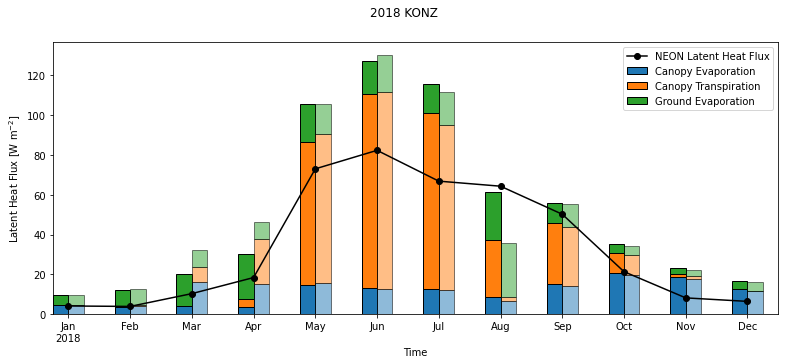

In [42]:
def line_format(label):
    """
    Helper function to convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month


plt.figure(num=None, figsize=(13, 5),  facecolor='w', edgecolor='k')
ax = plt.gca()

df_monthly.plot ( x= 'time', y = 'EFLX_LH_TOT' , marker = 'o' ,ax =ax , color = 'black',label="NEON Latent Heat Flux",use_index=False)
df_monthly[['time','sim_FCEV_orig','sim_FCTR_orig','sim_FGEV_orig']].plot.bar ( x= 'time',stacked='True',ax=ax,rot=0,align='edge',width= -0.25,edgecolor = "black")
df_monthly[['time','sim_FCEV_mod','sim_FCTR_mod','sim_FGEV_mod']].plot.bar ( x= 'time',stacked='True',ax=ax,rot=0,align='edge',width= 0.25,edgecolor = "black", alpha =0.5)
# Modified case has lighter shading.
ax.set_xticklabels(map(line_format, df_monthly.time))

#set labels for the legend
ax.legend(["NEON Latent Heat Flux", "Canopy Evaporation", "Canopy Transpiration", "Ground Evaporation"]);

plt.xlabel('Time')
plt.ylabel("Latent Heat Flux [W m$^{-2}$]")
plt.suptitle(year+" "+neon_site)
plt.show()

The monthly averages of NEON latent heat flux observation are plotted as a line on top of the barplot of CLM data for reference.  The modified case has lighter shading.

Both simulations have high biases in latent heat flux in the summer.  This pattern is similar to the high GPP that we saw in earlier plots.

#### **Questions to consider:**
1. Which components of latent heat flux changed by changing the rain threshhold for leaf onset? When are these changes most noticable?
1. Which months does original CLM simulation overestimate and underestimate observed latent heat fluxes for this site? 
1. What times of year is *canopy transpiration* the largest contributor to the total CLM latent heat flux? How does it change between the two simulations?
1. What times of year are *canopy evaporation* and *ground evaporation* important contributors to the total CLM latent heat flux?  How do these change between the two simulations?
1. What is the dominant component flux when CLM overestimates observed latent heat fluxes? When CLM underestimates latent heat fluxes?
****

### 5.3 Annual Correlations
Scatter plots can help to describe the relationship between latent heat flux and the component transpiration and evaporation fluxes. We can look at these relationships using data from CLM simulations.

First, plot annual average relationships for the original simulation.

*Run the cells below to first define a generic function that plot scatter diagrams and add a regression line, and then to generate the plots.*

In [43]:
#Defining generic function for scatter plots
def detailed_scatter (x, y, color):
    plt.scatter (x,y, marker="o",color = color)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    line = slope*x+intercept
    plt.plot(x,line,'black', label='y={:.2f}x+{:.2f}'.format(slope,intercept)+" (R2="+"{:.2f}".format(r_value)+")")
    plt.legend(fontsize=13)

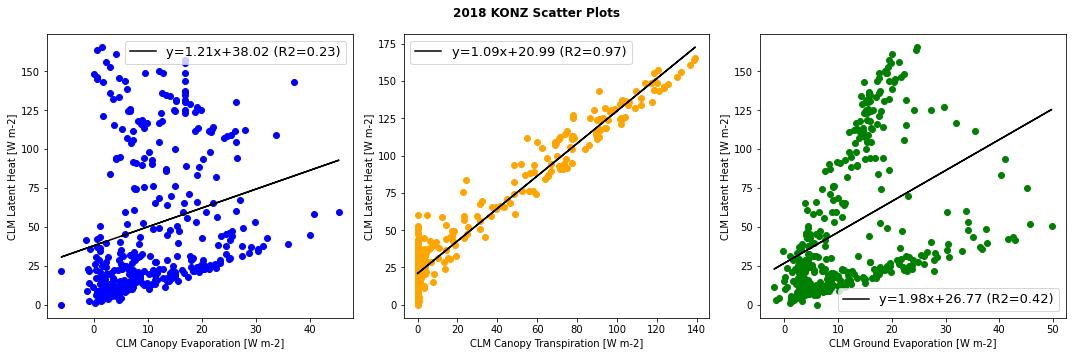

In [44]:
#Generating plots
plt.figure(num=None, figsize=(15, 5),  facecolor='w', edgecolor='k')

plt.subplot(1, 3, 1)
detailed_scatter (df_daily.sim_FCEV_orig, df_daily.sim_EFLX_LH_TOT_orig, 'b')
plt.ylabel('CLM Latent Heat [W m-2]')
plt.xlabel('CLM Canopy Evaporation [W m-2]')

plt.subplot(1, 3, 2)
detailed_scatter (df_daily.sim_FCTR_orig, df_daily.sim_EFLX_LH_TOT_orig, 'orange')

plt.ylabel('CLM Latent Heat [W m-2]')
plt.xlabel('CLM Canopy Transpiration [W m-2]')

plt.subplot(1, 3, 3)
detailed_scatter (df_daily.sim_FGEV_orig, df_daily.sim_EFLX_LH_TOT_orig,'green')

plt.ylabel('CLM Latent Heat [W m-2]')
plt.xlabel('CLM Ground Evaporation [W m-2]')

plt.suptitle(year+" "+neon_site+" Scatter Plots", fontweight='bold')

plt.tight_layout()
plt.show()

#### **Questions to consider**: 
1. Which component flux has the strongest relationship with total latent heat flux
1. The plots show data for the full year. How do you think the relationships might change by season? 

#### **Challenge:** Can you make a similar plot for the modified simulation?